In [97]:
# =============================================================================
# CHICAGO TAXI TRIPS DATA ANALYSIS
# =============================================================================
# This notebook analyzes Chicago taxi trips and weather data
# loaded from S3 bucket

import os
import boto3
import pandas as pd
from io import StringIO
from dotenv import load_dotenv
from typing import Optional
import matplotlib.pyplot as plt

# Load environment variables
load_dotenv()

# Pandas display settings
pd.set_option("display.max_columns", 50)
pd.set_option("display.precision", 2)

In [98]:
# =============================================================================
# AWS CONNECTION SETUP
# =============================================================================

# Load AWS credentials from environment variables
aws_access_key_id = os.getenv("AWS_ACCESS_KEY")
aws_secret_key = os.getenv("AWS_SECRET_KEY")

# Security check
if not aws_access_key_id or not aws_secret_key:
    raise ValueError("AWS credentials are missing! Check your .env file.")

print("AWS credentials loaded successfully")

AWS credentials loaded successfully


In [99]:
# =============================================================================
# S3 CSV READER FUNCTION
# =============================================================================

def read_csv_from_s3(bucket: str, path: str, filename: str) -> pd.DataFrame:
    """
    Download and read CSV file from S3 bucket.
    
    Args:
        bucket: S3 bucket name
        path: Path to the file
        filename: File name
        
    Returns:
        DataFrame with loaded data
        
    Raises:
        Exception: If file not found or error occurs
    """
    try:
        # Create S3 client
        s3 = boto3.client(
            "s3",
            aws_access_key_id=aws_access_key_id,
            aws_secret_access_key=aws_secret_key
        )
        
        # Build full file path
        full_path = f"{path}{filename}"
        
        # Download and read file
        obj = s3.get_object(Bucket=bucket, Key=full_path)
        data = obj["Body"].read().decode("utf-8")
        
        # Create DataFrame
        output_df = pd.read_csv(StringIO(data))
        
        print(f"{filename} loaded successfully ({len(output_df):,} rows)")
        return output_df
        
    except Exception as e:
        print(f"Error loading {filename}: {str(e)}")
        raise

In [100]:
# =============================================================================
# S3 CONFIGURATION AND PATHS
# =============================================================================

# Initialize S3 client
s3_client = boto3.client(
    "s3",
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_key
)

# S3 bucket and data paths
BUCKET_NAME = "cubixchicagodata"

DATA_PATHS = {
    "community_areas": "transformed_data/community_areas/",
    "company": "transformed_data/company/",
    "date": "transformed_data/date/",
    "payment_type": "transformed_data/payment_type/",
    "taxi_trips": "transformed_data/taxi_trips/",
    "weather": "transformed_data/weather/"
}

print("S3 client and paths configured")

S3 client and paths configured


In [101]:
# =============================================================================
# LOADING MASTER DATA
# =============================================================================

print("Loading master data...")

# Community areas data
community_areas = read_csv_from_s3(
    BUCKET_NAME, 
    DATA_PATHS["community_areas"], 
    "community_areas_master.csv"
)

# Company data
company = read_csv_from_s3(
    BUCKET_NAME, 
    DATA_PATHS["company"], 
    "company_master.csv"
)

# Date dimension data
date = read_csv_from_s3(
    BUCKET_NAME, 
    DATA_PATHS["date"], 
    "date_dimension.csv"
)

# Payment type data
payment_type = read_csv_from_s3(
    BUCKET_NAME,
    DATA_PATHS["payment_type"],
    "payment_type_master.csv"
)

print(f"\nLoaded master data:")
print(f"   • Community areas: {len(community_areas):,} rows")
print(f"   • Companies: {len(company):,} rows")
print(f"   • Dates: {len(date):,} rows")
print(f"   • Payment types: {len(payment_type):,} rows")

Loading master data...
community_areas_master.csv loaded successfully (77 rows)
company_master.csv loaded successfully (37 rows)
date_dimension.csv loaded successfully (1,827 rows)
payment_type_master.csv loaded successfully (7 rows)

Loaded master data:
   • Community areas: 77 rows
   • Companies: 37 rows
   • Dates: 1,827 rows
   • Payment types: 7 rows


In [102]:
# =============================================================================
# LOADING TAXI TRIPS DATA - DYNAMIC DATE RANGE
# =============================================================================

print("Loading taxi trips data from S3...")

trips_list = []

# List and load taxi files from S3 - automatically detects available dates
taxi_files = []
for file in s3_client.list_objects(Bucket=BUCKET_NAME, Prefix=DATA_PATHS["taxi_trips"])["Contents"]:
    file_key = file["Key"]
    filename = file_key.split("/")[-1]
    
    # Process only CSV files
    if filename.strip() and filename.endswith(".csv") and "taxi_" in filename:
        taxi_files.append(filename)

# Sort files by date to get proper chronological order
taxi_files.sort()

print(f"Found {len(taxi_files)} taxi data files:")
for filename in taxi_files:
    print(f"   • {filename}")

# Load all available taxi files
for filename in taxi_files:
    print(f"   Processing: {filename}")
    
    trip_data = read_csv_from_s3(BUCKET_NAME, DATA_PATHS["taxi_trips"], filename)
    trips_list.append(trip_data)

# Combine all taxi trips
taxi_trips = pd.concat(trips_list, ignore_index=True)

# Get date range for titles
first_date = taxi_files[0].replace("taxi_", "").replace(".csv", "") if taxi_files else "N/A"
last_date = taxi_files[-1].replace("taxi_", "").replace(".csv", "") if taxi_files else "N/A"

print(f"\nTaxi trips summary:")
print(f"   • Processed files: {len(trips_list)}")
print(f"   • Total trips: {len(taxi_trips):,} rows")
print(f"   • Number of columns: {len(taxi_trips.columns)}")
print(f"   • Date range: {first_date} to {last_date}")

# Store date range for chart titles
global_date_range = f"{first_date} to {last_date}"

Loading taxi trips data from S3...
Found 4 taxi data files:
   • taxi_2025-07-08.csv
   • taxi_2025-07-09.csv
   • taxi_2025-07-10.csv
   • taxi_2025-07-11.csv
   Processing: taxi_2025-07-08.csv
taxi_2025-07-08.csv loaded successfully (17,041 rows)
   Processing: taxi_2025-07-09.csv
taxi_2025-07-09.csv loaded successfully (17,723 rows)
   Processing: taxi_2025-07-10.csv
taxi_2025-07-10.csv loaded successfully (19,417 rows)
   Processing: taxi_2025-07-11.csv
taxi_2025-07-11.csv loaded successfully (18,558 rows)

Taxi trips summary:
   • Processed files: 4
   • Total trips: 72,739 rows
   • Number of columns: 22
   • Date range: 2025-07-08 to 2025-07-11


In [103]:
# View taxi trips data structure
taxi_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72739 entries, 0 to 72738
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   trip_id                     72739 non-null  object 
 1   taxi_id                     72739 non-null  object 
 2   trip_start_timestamp        72739 non-null  object 
 3   trip_end_timestamp          72739 non-null  object 
 4   trip_seconds                72739 non-null  int64  
 5   trip_miles                  72739 non-null  float64
 6   pickup_community_area_id    72739 non-null  int64  
 7   dropoff_community_area_id   72739 non-null  int64  
 8   fare                        72739 non-null  float64
 9   tips                        72739 non-null  float64
 10  tolls                       72739 non-null  float64
 11  extras                      72739 non-null  float64
 12  trip_total                  72739 non-null  float64
 13  payment_type                727

In [104]:
# =============================================================================
# LOADING WEATHER DATA
# =============================================================================

print("Loading weather data from S3...")

weather_list = []

# List and load weather files from S3
for file in s3_client.list_objects(Bucket=BUCKET_NAME, Prefix=DATA_PATHS["weather"])["Contents"]:
    file_key = file["Key"]
    filename = file_key.split("/")[-1]
    
    # Process only CSV files
    if filename.strip() and filename.endswith(".csv"):
        print(f"   Processing: {filename}")
        
        weather_data = read_csv_from_s3(BUCKET_NAME, DATA_PATHS["weather"], filename)
        weather_list.append(weather_data)

# Combine all weather data
weather = pd.concat(weather_list, ignore_index=True)

print(f"\nWeather data summary:")
print(f"   • Processed files: {len(weather_list)}")
print(f"   • Total weather records: {len(weather):,} rows")
print(f"   • Number of columns: {len(weather.columns)}")

Loading weather data from S3...
   Processing: weather_2025-06-28.csv
weather_2025-06-28.csv loaded successfully (24 rows)
   Processing: weather_2025-06-29.csv
weather_2025-06-29.csv loaded successfully (24 rows)
   Processing: weather_2025-06-30.csv
weather_2025-06-30.csv loaded successfully (24 rows)
   Processing: weather_2025-07-01.csv
weather_2025-07-01.csv loaded successfully (24 rows)
   Processing: weather_2025-07-02.csv
weather_2025-07-02.csv loaded successfully (24 rows)
   Processing: weather_2025-07-03.csv
weather_2025-07-03.csv loaded successfully (24 rows)
   Processing: weather_2025-07-04.csv
weather_2025-07-04.csv loaded successfully (24 rows)
   Processing: weather_2025-07-05.csv
weather_2025-07-05.csv loaded successfully (24 rows)
   Processing: weather_2025-07-06.csv
weather_2025-07-06.csv loaded successfully (24 rows)
   Processing: weather_2025-07-07.csv
weather_2025-07-07.csv loaded successfully (24 rows)
   Processing: weather_2025-07-08.csv
weather_2025-07-08.c

In [105]:
# View weather data sample
weather.head()

,datetime,temperature,wind_speed,rain,precipitation
0,2025-06-28 00:00:00,27.4,14.3,0.0,0.0
1,2025-06-28 01:00:00,26.5,10.9,0.0,0.0
2,2025-06-28 02:00:00,25.2,10.5,0.0,0.0
3,2025-06-28 03:00:00,24.4,8.3,0.0,0.0
4,2025-06-28 04:00:00,23.6,6.6,0.0,0.0


In [106]:
# View community areas sample
community_areas.head()

,area_code,community_name
0,1,Rogers Park
1,2,West Ridge
2,3,Uptown
3,4,Lincoln Square
4,5,North Center


In [107]:
# View company table sample
company.head()

,company_id,company
0,1,Taxicab Insurance Agency Llc
1,2,Taxi Affiliation Services
2,3,Blue Ribbon Taxi Association
3,4,Flash Cab
4,5,5 Star Taxi


In [108]:
# View date dimension sample
date.head()

,Date,year,month,day,day_of_week,is_weekend
0,2023-01-01,2023,1,1,7,True
1,2023-01-02,2023,1,2,1,False
2,2023-01-03,2023,1,3,2,False
3,2023-01-04,2023,1,4,3,False
4,2023-01-05,2023,1,5,4,False


In [109]:
# View payment types sample
payment_type.head()

,payment_type_id,payment_type
0,1,Mobile
1,2,Unknown
2,3,Cash
3,4,Credit Card
4,5,No Charge


# =============================================================================
# DATA MERGING AND RELATIONSHIPS
# =============================================================================

In [110]:
# 1. MERGE TAXI TRIPS AND WEATHER DATA
print("Merging taxi trips and weather data...")

trips_full = pd.merge(
    taxi_trips,
    weather,
    left_on="datetime_for_weather",
    right_on="datetime",
    how="inner"
)

# Remove duplicate datetime column
trips_full = trips_full.drop(columns=["datetime"])

print(f"Merged rows: {len(trips_full):,}")

Merging taxi trips and weather data...
Merged rows: 72,739


In [111]:
# 2. ADD COMPANY DATA
print("Adding company data...")

trips_full = pd.merge(
    trips_full,
    company,
    on="company_id",
    how="inner"
)

# Remove duplicate company_id column (keep company_x)
trips_full = trips_full.drop(columns=["company_id"])

print(f"Rows with company data: {len(trips_full):,}")

Adding company data...
Rows with company data: 72,739


In [112]:
# 3. ADD PICKUP COMMUNITY AREAS
print("Adding pickup community areas...")

trips_full = pd.merge(
    trips_full,
    community_areas,
    left_on="pickup_community_area_id",
    right_on="area_code",
    how="inner"
)

# Remove unnecessary columns and rename
trips_full = trips_full.drop(columns=["pickup_community_area_id", "area_code"])
trips_full = trips_full.rename(columns={"community_name": "pickup_community_area_name"})

print(f"Rows with pickup areas: {len(trips_full):,}")

Adding pickup community areas...
Rows with pickup areas: 72,739


In [113]:
# 4. ADD DROPOFF COMMUNITY AREAS
print("Adding dropoff community areas...")

trips_full = pd.merge(
    trips_full,
    community_areas,
    left_on="dropoff_community_area_id",
    right_on="area_code",
    how="inner"
)

# Remove unnecessary columns and rename
trips_full = trips_full.drop(columns=["dropoff_community_area_id", "area_code"])
trips_full = trips_full.rename(columns={"community_name": "dropoff_community_area_name"})

print(f"Rows with dropoff areas: {len(trips_full):,}")

Adding dropoff community areas...
Rows with dropoff areas: 72,739


In [114]:
# =============================================================================
# DATE DATA PREPARATION AND NORMALIZATION
# =============================================================================

print("Preparing date data...")

# Normalize date table column names
date.columns = date.columns.str.strip().str.lower()

# Set date types
date["date"] = pd.to_datetime(date["date"])
trips_full["trip_start_timestamp"] = pd.to_datetime(trips_full["trip_start_timestamp"])

# Extract trip start date (day precision only)
trips_full["trip_start_date"] = trips_full["trip_start_timestamp"].dt.date
trips_full["trip_start_date"] = pd.to_datetime(trips_full["trip_start_date"])

print("Date types set and normalized")

Preparing date data...
Date types set and normalized


In [115]:
# 5. ADD DATE DIMENSION
print("Adding date dimension...")

trips_full = pd.merge(
    trips_full,
    date,
    left_on="trip_start_date",
    right_on="date",
    how="inner"
)

# Remove duplicate date column
trips_full = trips_full.drop(columns=["date"])

print(f"Rows with date dimensions: {len(trips_full):,}")
print(f"Final dataset columns: {len(trips_full.columns)}")

Adding date dimension...
Rows with date dimensions: 72,739
Final dataset columns: 32


In [116]:
# =============================================================================
# FINAL DATASET OVERVIEW
# =============================================================================

print("Final merged dataset:")
print(f"   • Total records: {len(trips_full):,}")
print(f"   • Number of columns: {len(trips_full.columns)}")
print(f"   • Memory usage: {trips_full.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# View first few rows
trips_full.head()

Final merged dataset:
   • Total records: 72,739
   • Number of columns: 32
   • Memory usage: 61.8 MB


,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,payment_type,company_x,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,datetime_for_weather,payment_type_id,temperature,wind_speed,rain,precipitation,company_y,pickup_community_area_name,dropoff_community_area_name,trip_start_date,year,month,day,day_of_week,is_weekend
0,567bd03d5aa8e60e33845dbd143d3b0b99fc414f,f231bcdb9ecc171d44032640fced8351f4bcf6542b673e...,2025-07-08 23:45:00,2025-07-08T23:45:00.000,413,0.00,5.50,0.00,0.0,0.0,5.50,Cash,Taxicab Insurance Agency Llc,41.98,-87.90,41.98,-87.90,2025-07-08 23:00:00,3,29.8,10.1,0.0,0.0,Taxicab Insurance Agency Llc,O'Hare,O'Hare,2025-07-08,2025,7,8,2,False
1,50c6c371fb4d39e618b827438a10a771b9a07b29,c52371aa17a6dd092799762c903f7c4b67d720a67d23b5...,2025-07-08 23:45:00,2025-07-09T00:15:00.000,1664,18.26,45.50,0.00,0.0,4.0,49.50,Cash,City Service,41.98,-87.91,41.90,-87.63,2025-07-08 23:00:00,3,29.8,10.1,0.0,0.0,City Service,O'Hare,Near North Side,2025-07-08,2025,7,8,2,False
2,4ea59ec1bc31e17594a9e93da31e0ce77b77e9d6,f54b11bc86d1ab32945f60547e15cbdc14a3b017b2a0ee...,2025-07-08 23:45:00,2025-07-09T00:15:00.000,1701,17.74,44.00,7.28,0.0,4.0,55.78,Credit Card,Blue Ribbon Taxi Association,41.98,-87.91,41.90,-87.63,2025-07-08 23:00:00,4,29.8,10.1,0.0,0.0,Blue Ribbon Taxi Association,O'Hare,Near North Side,2025-07-08,2025,7,8,2,False
3,4e1a12ec4d8ff08aefabed611ece15d7ee9b350e,2e82e26afb77e809fe4a44b02a152bdc079623600ae1b7...,2025-07-08 23:45:00,2025-07-08T23:45:00.000,360,1.00,6.00,0.00,0.0,0.0,6.00,Cash,Taxi Affiliation Services,41.89,-87.62,41.88,-87.63,2025-07-08 23:00:00,3,29.8,10.1,0.0,0.0,Taxi Affiliation Services,Near North Side,Loop,2025-07-08,2025,7,8,2,False
4,4d5f4e4fc7e4de256a4f9f61de59b9c9abc56658,d84c3b3515e9b0be353baccf4cfba1e0cef7e656261dc5...,2025-07-08 23:45:00,2025-07-09T00:15:00.000,1860,14.20,36.75,0.00,0.0,0.0,36.75,Cash,Taxi Affiliation Services,41.90,-87.63,41.78,-87.77,2025-07-08 23:00:00,3,29.8,10.1,0.0,0.0,Taxi Affiliation Services,Near North Side,Clearing,2025-07-08,2025,7,8,2,False


Payment methods distribution:
   • Total payments: 72,739
   • Credit Card: 24,660 (33.9%)
   • Cash: 17,826 (24.5%)
   • Mobile: 17,567 (24.2%)
   • Prcard: 9,568 (13.2%)
   • Unknown: 2,842 (3.9%)
   • No Charge: 227 (0.3%)
   • Dispute: 49 (0.1%)


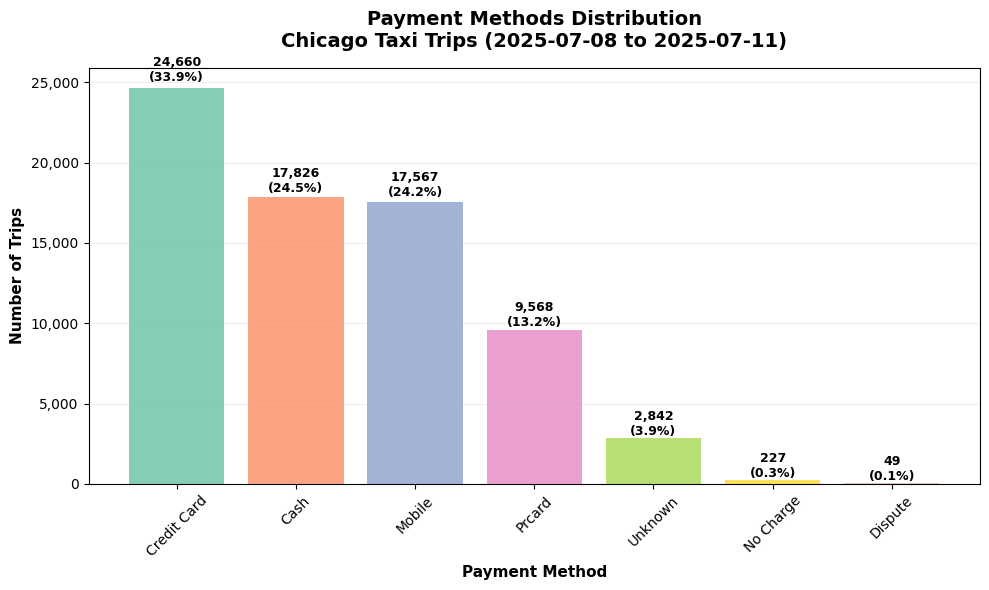


Summary:
   • Most common payment method: Credit Card (24,660 trips)
   • Least common payment method: Dispute (49 trips)
   • Cash vs. electronic ratio: 17,826 vs. 42,227


In [117]:
# =============================================================================
# PAYMENT METHODS DISTRIBUTION
# =============================================================================

# Get payment type counts and sort
payment_counts = trips_full['payment_type'].value_counts().sort_values(ascending=False)
total_payments = payment_counts.sum()
payment_methods = payment_counts.index
payment_values = payment_counts.values

# Calculate percentages
percentages = (payment_values / total_payments) * 100

print("Payment methods distribution:")
print(f"   • Total payments: {total_payments:,}")

# Detailed breakdown
for method, value, pct in zip(payment_methods, payment_values, percentages):
    print(f"   • {method}: {value:,} ({pct:.1f}%)")

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.Set2(range(len(payment_counts)))

bars = ax.bar(payment_methods, payment_values, color=colors, alpha=0.8)

# Dynamic title with current date range
ax.set_title(f'Payment Methods Distribution\nChicago Taxi Trips ({global_date_range})', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Payment Method', fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Trips', fontsize=11, fontweight='bold')

# Y-axis formatting
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

# Values on top of bars
for bar, value, pct in zip(bars, payment_values, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
            f'{int(value):,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=9)

# Grid and layout
ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Summary
most_common = payment_methods[0]
least_common = payment_methods[-1]
cash_count = payment_counts.get('Cash', 0)
electronic_count = payment_counts.get('Credit Card', 0) + payment_counts.get('Mobile', 0)

print(f"\nSummary:")
print(f"   • Most common payment method: {most_common} ({payment_values[0]:,} trips)")
print(f"   • Least common payment method: {least_common} ({payment_values[-1]:,} trips)")
print(f"   • Cash vs. electronic ratio: {cash_count:,} vs. {electronic_count:,}")

Taxi company performance:
   • Total companies: 35
   • Total trips: 72,739

Top 5 companies market share:
   1. Flash Cab: 14,785 (20.3%)
   2. Taxi Affiliation Services: 11,216 (15.4%)
   3. Taxicab Insurance Agency Llc: 9,020 (12.4%)
   4. City Service: 7,859 (10.8%)
   5. Sun Taxi: 7,113 (9.8%)


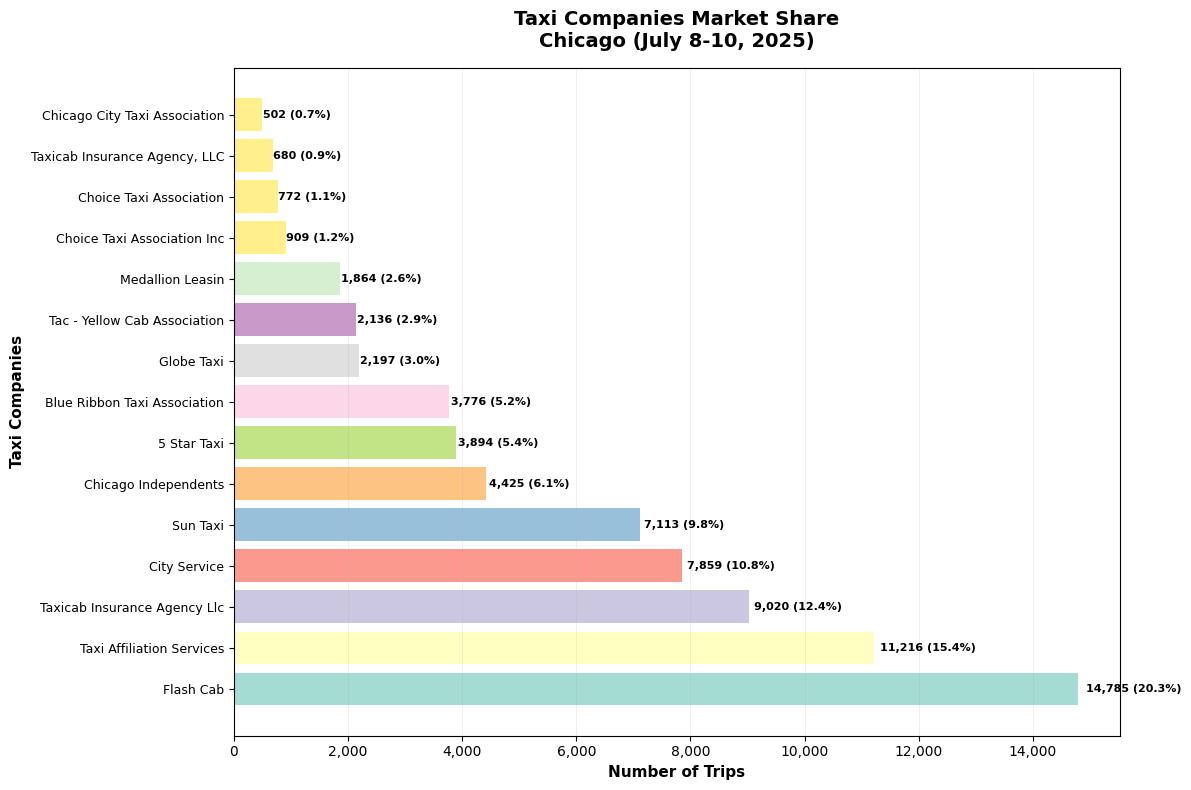


Market concentration analysis:
   • Top 5 companies market share: 68.7%
   • Top 10 companies market share: 91.3%
   • Market leader: Flash Cab (20.3%)
   • Small companies (1-50 trips): 8 companies


In [118]:
# =============================================================================
# TAXI COMPANY PERFORMANCE
# =============================================================================

# Company-wise calculations
company_counts = trips_full['company_x'].value_counts()
total_trips = company_counts.sum()
total_companies = len(company_counts)

# Select top 15 companies
top_companies = company_counts.head(15)
top_companies_values = top_companies.values
top_companies_names = top_companies.index

# Calculate percentages
percentages = (top_companies_values / total_trips) * 100

print("Taxi company performance:")
print(f"   • Total companies: {total_companies}")
print(f"   • Total trips: {total_trips:,}")

# Top 5 breakdown
print(f"\nTop 5 companies market share:")
for i in range(min(5, len(top_companies))):
    print(f"   {i+1}. {top_companies_names[i]}: {top_companies_values[i]:,} ({percentages[i]:.1f}%)")

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.Set3(range(len(top_companies)))

bars = ax.barh(range(len(top_companies)), top_companies_values, 
               color=colors, alpha=0.8)

# Labels and formatting
ax.set_title('Taxi Companies Market Share\nChicago (July 8-10, 2025)', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Number of Trips', fontsize=11, fontweight='bold')
ax.set_ylabel('Taxi Companies', fontsize=11, fontweight='bold')

# Y-axis labels
ax.set_yticks(range(len(top_companies)))
ax.set_yticklabels(top_companies_names, fontsize=9)

# X-axis formatting
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

# Values at the end of bars
for i, (bar, percentage) in enumerate(zip(bars, percentages)):
    width = bar.get_width()
    ax.text(width + width*0.01, bar.get_y() + bar.get_height()/2,
            f'{int(width):,} ({percentage:.1f}%)',
            ha='left', va='center', fontweight='bold', fontsize=8)

# Grid and layout
ax.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

# Market analysis
top_5_count = top_companies_values[:5].sum() if len(top_companies) >= 5 else top_companies_values.sum()
top_10_count = top_companies_values[:10].sum() if len(top_companies) >= 10 else top_companies_values.sum()
top_5_share = (top_5_count / total_trips) * 100
top_10_share = (top_10_count / total_trips) * 100
leader_share = (top_companies_values[0] / total_trips) * 100
small_companies_count = len(company_counts[company_counts <= 50])

print(f"\nMarket concentration analysis:")
print(f"   • Top 5 companies market share: {top_5_share:.1f}%")
print(f"   • Top 10 companies market share: {top_10_share:.1f}%")
print(f"   • Market leader: {top_companies_names[0]} ({leader_share:.1f}%)")
print(f"   • Small companies (1-50 trips): {small_companies_count} companies")

Peak hours analysis:
   • Total trips: 72,739

TOP 3 busiest hours:
   • 17:00 hour - 5433 trips
   • 16:00 hour - 5259 trips
   • 15:00 hour - 5166 trips


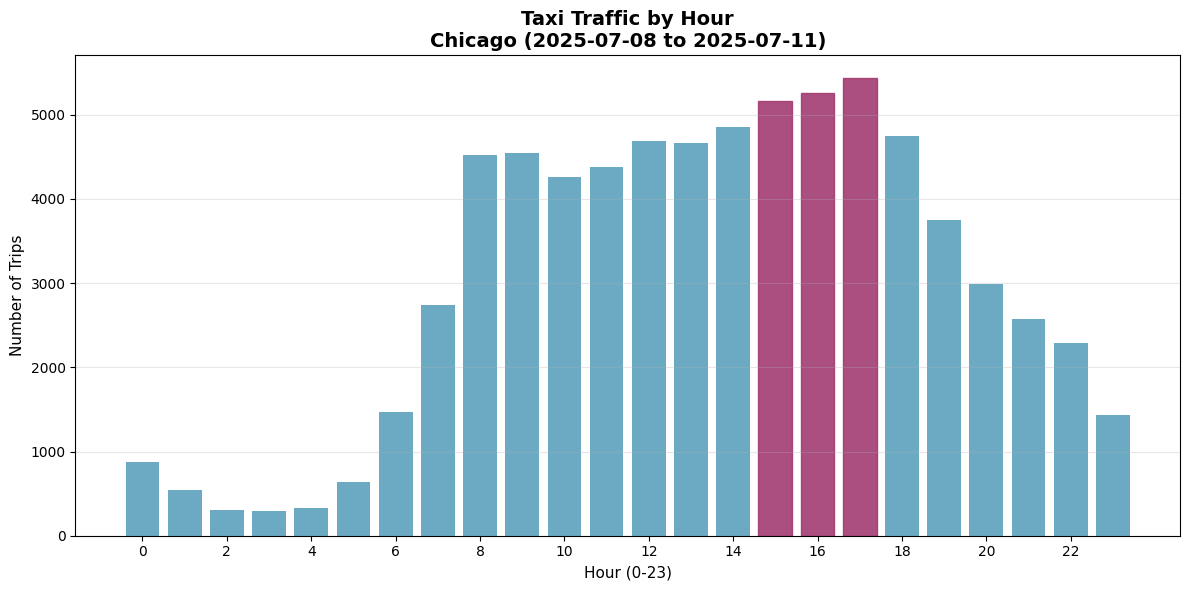


Daily time periods:
   • Morning (06-11): 21,904 trips (30%)
   • Afternoon (12-17): 30,066 trips (41%)
   • Evening (18-23): 17,794 trips (24%)
   • Night (00-05): 2,975 trips (4%)


In [119]:
# =============================================================================
# PEAK HOURS ANALYSIS
# =============================================================================

# Extract hours
trips_full['trip_start_timestamp'] = pd.to_datetime(trips_full['trip_start_timestamp'], errors='coerce')
trips_full['hour'] = trips_full['trip_start_timestamp'].dt.hour

# Hourly calculations
hourly_stats = (
    trips_full
    .groupby('hour', sort=True)
    .agg(trip_count=('trip_id', 'count'),
         avg_fare=('trip_total', 'mean'))
    .reindex(range(24))         # ensure 0-23 hours
    .fillna(0)
    .round(2)
)

print("Peak hours analysis:")
print(f"   • Total trips: {int(hourly_stats['trip_count'].sum()):,}")

# Top hours
top_hours = hourly_stats.nlargest(3, 'trip_count')
print("\nTOP 3 busiest hours:")
for hour, row in top_hours.iterrows():
    print(f"   • {int(hour):02d}:00 hour - {int(row['trip_count'])} trips")

# Create bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(hourly_stats.index, hourly_stats['trip_count'], color='#2E86AB', alpha=0.7)

# Dynamic title with current date range
ax.set_title(f'Taxi Traffic by Hour\nChicago ({global_date_range})', fontsize=14, fontweight='bold')
ax.set_xlabel('Hour (0-23)', fontsize=11)
ax.set_ylabel('Number of Trips', fontsize=11)
ax.set_xticks(range(0, 24, 2))
ax.grid(axis='y', alpha=0.3)

# Highlight peak hours
index_list = list(hourly_stats.index)
for h in top_hours.index:
    i = index_list.index(h)
    bars[i].set_color('#A23B72')
    bars[i].set_alpha(0.9)

plt.tight_layout()
plt.show()

# Time periods
morning   = int(hourly_stats.loc[6:11]['trip_count'].sum())   # 06-11
afternoon = int(hourly_stats.loc[12:17]['trip_count'].sum())  # 12-17
evening   = int(hourly_stats.loc[18:23]['trip_count'].sum())  # 18-23
night     = int(hourly_stats.loc[0:5]['trip_count'].sum())    # 00-05

total = morning + afternoon + evening + night if hourly_stats['trip_count'].sum() == 0 else int(hourly_stats['trip_count'].sum())

print("\nDaily time periods:")
if total > 0:
    print(f"   • Morning (06-11): {morning:,} trips ({morning/total*100:.0f}%)")
    print(f"   • Afternoon (12-17): {afternoon:,} trips ({afternoon/total*100:.0f}%)")
    print(f"   • Evening (18-23): {evening:,} trips ({evening/total*100:.0f}%)")
    print(f"   • Night (00-05): {night:,} trips ({night/total*100:.0f}%)")
else:
    print("   • Not enough data for percentages.")

WHERE DO TAXI DRIVERS MAKE THE MOST MONEY?
TOP 10 MONEY-MAKING PICKUP AREAS:
 1. O'Hare                    - $ 564,909 total ($52.91 avg, 10677 trips)
 2. Near North Side           - $ 275,017 total ($15.07 avg, 18248 trips)
 3. Loop                      - $ 202,654 total ($14.99 avg, 13515 trips)
 4. Near West Side            - $ 130,456 total ($14.49 avg, 9003 trips)
 5. Garfield Ridge            - $  86,798 total ($44.24 avg, 1962 trips)
 6. Near South Side           - $  47,810 total ($20.40 avg, 2344 trips)
 7. Lake View                 - $  44,270 total ($19.50 avg, 2270 trips)
 8. Lincoln Park              - $  28,471 total ($17.16 avg, 1659 trips)
 9. Uptown                    - $  26,735 total ($20.07 avg, 1332 trips)
10. Hyde Park                 - $  23,962 total ($31.53 avg,  760 trips)


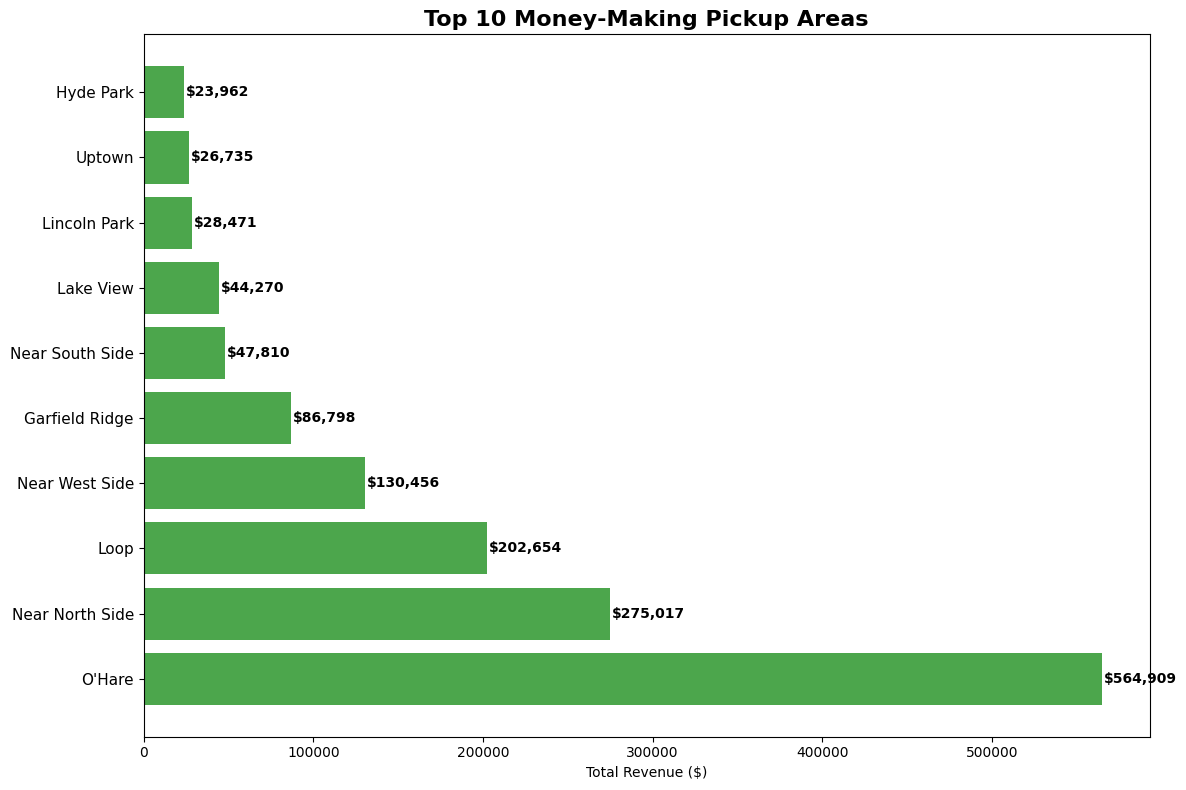


CONCLUSION:
BEST AREA FOR DRIVERS: O'Hare (AIRPORT)
TOTAL REVENUE: $564,909
AVERAGE FARE: $52.91
NUMBER OF TRIPS: 10677

WHY AIRPORT WINS:
• Longest trips = highest fares
• International travelers = willing to pay premium
• Less price-sensitive customers
• Consistent demand 24/7

PRACTICAL ADVICE FOR DRIVERS:
• Best money: Wait at O'Hare Airport
• Best volume: Work downtown areas (Near North Side, Loop)
• Best balance: Mixed strategy depending on time of day

Simple but actionable - drivers know exactly where to go!


In [120]:
# =============================================================================
# SIMPLE USEFUL ANALYSIS: WHERE DO TAXI DRIVERS MAKE THE MOST MONEY?
# =============================================================================

print("WHERE DO TAXI DRIVERS MAKE THE MOST MONEY?")
print("="*50)

# Simple analysis: which pickup areas generate the most revenue
area_money = trips_full.groupby('pickup_community_area_name').agg({
    'trip_total': ['sum', 'mean', 'count']
}).round(2)

area_money.columns = ['total_revenue', 'avg_fare', 'trip_count']

# Only areas with decent number of trips
good_areas = area_money[area_money['trip_count'] >= 50]

print("TOP 10 MONEY-MAKING PICKUP AREAS:")
top_areas = good_areas.nlargest(10, 'total_revenue')
for i, (area, row) in enumerate(top_areas.iterrows(), 1):
    print(f"{i:2d}. {area:<25} - ${row['total_revenue']:>8,.0f} total (${row['avg_fare']:>5.2f} avg, {row['trip_count']:>4.0f} trips)")

# Simple bar chart
fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.barh(range(len(top_areas)), top_areas['total_revenue'], 
               color='green', alpha=0.7)

ax.set_title('Top 10 Money-Making Pickup Areas', fontweight='bold', fontsize=16)
ax.set_xlabel('Total Revenue ($)')
ax.set_yticks(range(len(top_areas)))
ax.set_yticklabels(top_areas.index, fontsize=11)

# Add money values
for i, (bar, revenue) in enumerate(zip(bars, top_areas['total_revenue'])):
    ax.text(bar.get_width() + 1000, bar.get_y() + bar.get_height()/2,
            f'${revenue:,.0f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nCONCLUSION:")
print(f"BEST AREA FOR DRIVERS: {top_areas.index[0]} (AIRPORT)")
print(f"TOTAL REVENUE: ${top_areas.iloc[0]['total_revenue']:,.0f}")
print(f"AVERAGE FARE: ${top_areas.iloc[0]['avg_fare']:.2f}")
print(f"NUMBER OF TRIPS: {top_areas.iloc[0]['trip_count']:.0f}")
print(f"\nWHY AIRPORT WINS:")
print(f"• Longest trips = highest fares")
print(f"• International travelers = willing to pay premium")
print(f"• Less price-sensitive customers")
print(f"• Consistent demand 24/7")
print(f"\nPRACTICAL ADVICE FOR DRIVERS:")
print(f"• Best money: Wait at O'Hare Airport")
print(f"• Best volume: Work downtown areas (Near North Side, Loop)")
print(f"• Best balance: Mixed strategy depending on time of day")

print(f"\nSimple but actionable - drivers know exactly where to go!")

Night pickup analysis by area:
   Total trips: 72,739
   Total night trips: 8,176
   Night hours definition: 22:00-06:00

Top 15 areas for night pickups:
   O'Hare: 2,100 trips (25.7%)
   Near North Side: 1,761 trips (21.5%)
   Loop: 890 trips (10.9%)
   Near West Side: 719 trips (8.8%)
   Garfield Ridge: 336 trips (4.1%)
   Lake View: 291 trips (3.6%)
   Near South Side: 244 trips (3.0%)
   Lincoln Park: 196 trips (2.4%)
   Uptown: 154 trips (1.9%)
   West Town: 110 trips (1.3%)
   Edgewater: 108 trips (1.3%)
   West Ridge: 91 trips (1.1%)
   Chatham: 63 trips (0.8%)
   Rogers Park: 61 trips (0.7%)
   Roseland: 54 trips (0.7%)


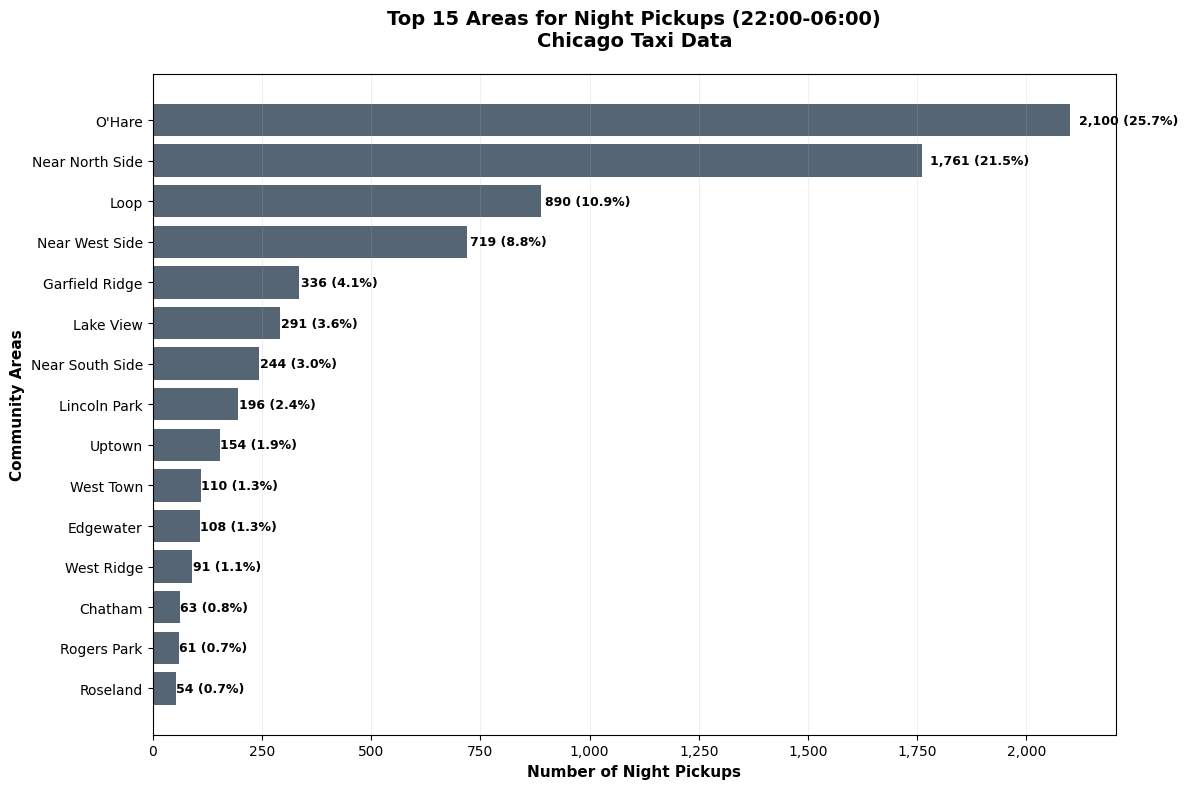


Night pickup concentration:
   Top 3 areas: 58.1% of night pickups
   Top 5 areas: 71.0% of night pickups
   Top 10 areas: 83.2% of night pickups

Areas with highest night pickup percentage:
   West Elsdon: 44.4% (8/18)
   West Garfield Park: 33.3% (10/30)
   Hermosa: 28.6% (2/7)
   Norwood Park: 24.2% (39/161)
   Forest Glen: 23.6% (26/110)
   Fuller Park: 23.5% (27/115)
   Roseland: 22.1% (54/244)
   Jefferson Park: 21.1% (19/90)
   West Pullman: 19.9% (45/226)
   O'Hare: 19.7% (2100/10677)

Top night pickup area: O'Hare
Night pickups: 2,100
Share of total night pickups: 25.7%


In [122]:
# =============================================================================
# NIGHT PICKUP ANALYSIS BY AREA 
# =============================================================================

# Define night hours (22:00 - 06:00)  
night_trips = trips_full[
    (trips_full['hour'] >= 22) | (trips_full['hour'] <= 6)
]

print("Night pickup analysis by area:")
print(f"   Total trips: {len(trips_full):,}")
print(f"   Total night trips: {len(night_trips):,}")
print(f"   Night hours definition: 22:00-06:00")

# Group by pickup area and count
night_pickups = (
    night_trips
    .groupby('pickup_community_area_name')
    .size()
    .reset_index(name='night_pickup_count')
    .sort_values('night_pickup_count', ascending=False)
)

# Get top 15 areas for night pickups
top_night_areas = night_pickups.head(15)

print(f"\nTop 15 areas for night pickups:")
for i, row in top_night_areas.iterrows():
    area = row['pickup_community_area_name']
    count = row['night_pickup_count']
    pct = (count / len(night_trips)) * 100
    print(f"   {area}: {count:,} trips ({pct:.1f}%)")

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.barh(range(len(top_night_areas)), 
               top_night_areas['night_pickup_count'],
               color='#2C3E50', alpha=0.8)

# Labels and formatting
ax.set_title('Top 15 Areas for Night Pickups (22:00-06:00)\nChicago Taxi Data', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Number of Night Pickups', fontsize=11, fontweight='bold')
ax.set_ylabel('Community Areas', fontsize=11, fontweight='bold')

# Y-axis labels
ax.set_yticks(range(len(top_night_areas)))
ax.set_yticklabels(top_night_areas['pickup_community_area_name'], fontsize=10)

# X-axis formatting
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

# Add values at the end of bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    count = top_night_areas.iloc[i]['night_pickup_count']
    pct = (count / len(night_trips)) * 100
    ax.text(width + width*0.01, bar.get_y() + bar.get_height()/2,
            f'{count:,} ({pct:.1f}%)',
            ha='left', va='center', fontweight='bold', fontsize=9)

# Grid and layout
ax.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.5)
ax.invert_yaxis()  # Top area at the top
plt.tight_layout()
plt.show()

# Analysis summary
total_night = len(night_trips)
top_3_count = top_night_areas.head(3)['night_pickup_count'].sum()
top_5_count = top_night_areas.head(5)['night_pickup_count'].sum()
top_10_count = top_night_areas.head(10)['night_pickup_count'].sum()

print(f"\nNight pickup concentration:")
print(f"   Top 3 areas: {(top_3_count/total_night)*100:.1f}% of night pickups")
print(f"   Top 5 areas: {(top_5_count/total_night)*100:.1f}% of night pickups")
print(f"   Top 10 areas: {(top_10_count/total_night)*100:.1f}% of night pickups")

# Compare with overall pickups
overall_pickups = (
    trips_full
    .groupby('pickup_community_area_name')
    .size()
    .reset_index(name='total_pickup_count')
)

# Merge night and total data
comparison = night_pickups.merge(overall_pickups, on='pickup_community_area_name')
comparison['night_percentage'] = (comparison['night_pickup_count'] / comparison['total_pickup_count']) * 100
comparison = comparison.sort_values('night_percentage', ascending=False)

print(f"\nAreas with highest night pickup percentage:")
for i, row in comparison.head(10).iterrows():
    area = row['pickup_community_area_name']
    night_pct = row['night_percentage']
    night_count = row['night_pickup_count']
    total_count = row['total_pickup_count']
    print(f"   {area}: {night_pct:.1f}% ({night_count}/{total_count})")

print(f"\nTop night pickup area: {top_night_areas.iloc[0]['pickup_community_area_name']}")
print(f"Night pickups: {top_night_areas.iloc[0]['night_pickup_count']:,}")
print(f"Share of total night pickups: {(top_night_areas.iloc[0]['night_pickup_count']/total_night)*100:.1f}%")

### Taxi vs. Weather Comparison

I don’t have enough data yet to properly compare taxi trips with weather data, but the dataset is updating daily.
